# Package Installation and Enviornment Initialization #

In [53]:
!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install backtrader --quiet #Backtesting trading strategies. 
!pip3 install scikit-learn --quiet #Performance metrics and Feature scaling
!pip3 install tensorflow --quiet #LSTM Development. 
!pip3 install keras-tuner --quiet #Hyper-parameter optimization

In [54]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt 
import backtrader as bt
import sklearn 
##
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 6] #Universal dimensions for all figures produced. 

# Real-Time Market Data via `yfinance` #

In [55]:
ticker = "ETH-USD" 
prices = yf.download(ticker, interval = "1D") #Imports the historical inter-day data for the given ticker.   
prices

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2024-08-31,2525.859131,2532.389893,2493.705566,2513.393799,2513.393799,6646876013
2024-09-01,2513.424316,2515.467285,2401.889160,2427.902344,2427.902344,11800443265
2024-09-02,2427.973389,2563.085938,2426.095947,2538.187256,2538.187256,12520444224


# Assessing Auto-Correlation #

The prescence of any statistically autocorrelation in the prices for the given security would justify the use of an autoregressive model like the Stacked LSTM. 

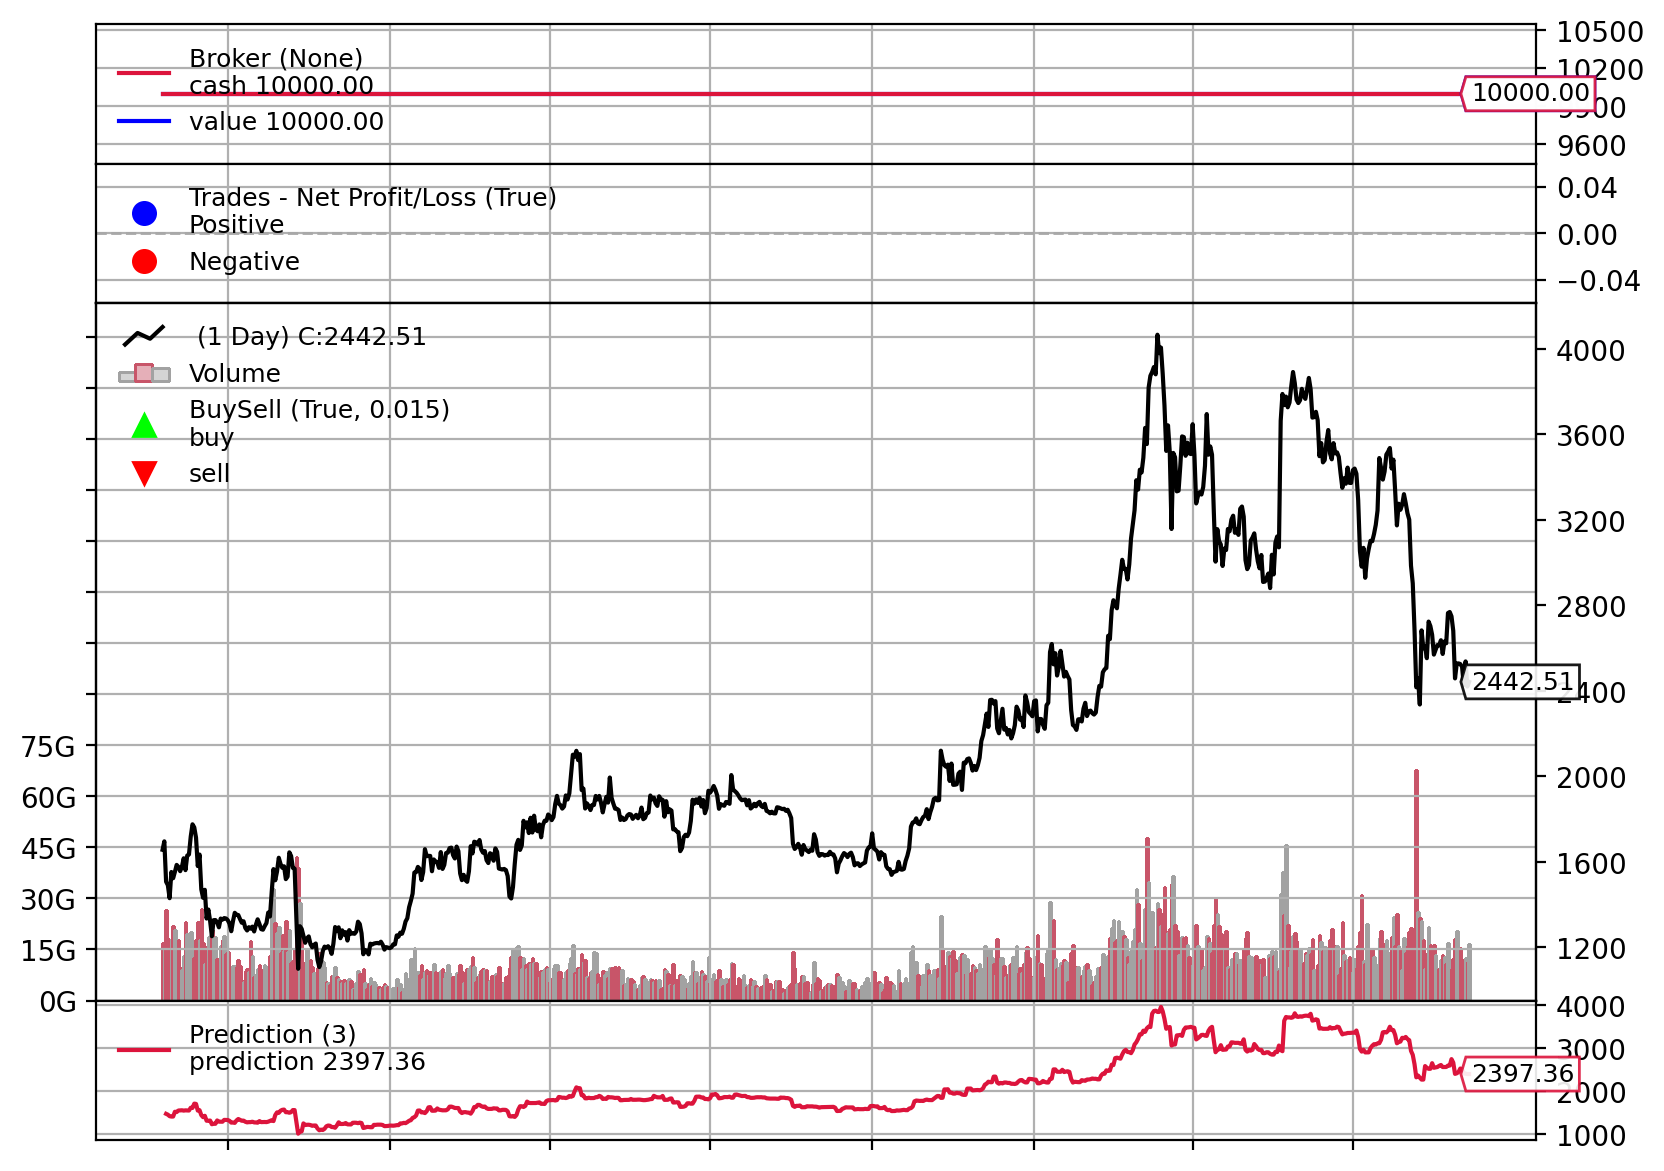

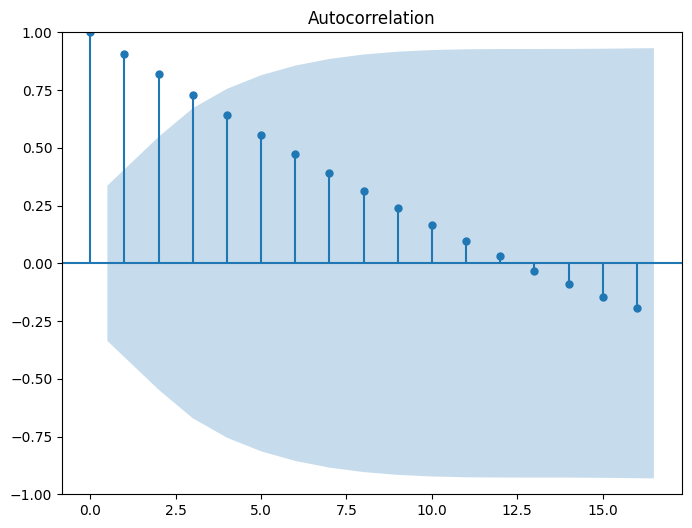

In [56]:
from statsmodels.tsa.stattools import acf; from statsmodels.graphics import tsaplots
autocorrelation_function = acf(prices["Close"].values)
fig = tsaplots.plot_acf(autocorrelation_function) 

# Building a Stacked LSTM Model Trained on Historical Market Data #

## Installing and Importing the Necessary Packages ##

In [57]:
import tensorflow as tf 
from tensorflow import keras; from tensorflow.keras import layers 
from keras_tuner.tuners import RandomSearch
from keras import regularizers
import keras_tuner

## Building and Initializing the Model ##

In this study, a Stacked LSTM Model of three LSTM layers and one Dense layer, with linear activation, was used. The primary advantage of such a stacked architecture over a model with only one LSTM layer is that it allows for hierarchial processing and provides our LSTM with more opportunities to capture and learn the more subtler patterns and behaviors that may exist within a highly non-linear time series. 

In [58]:
def lstm(hyper_params, input_features): 
    lstm = keras.Sequential() #Initializes an empty Sequential model
    #
    lstm_units = hyper_params.Int("lstm_units", min_value=30, max_value= 150, step = 5) #Number of neurons in each LSTM layer 
    #
    lstm.add(layers.LSTM(lstm_units, input_shape = (None, input_features), return_sequences = True)) #By assinging the first argument in `input_shape` as None, we provide our model with the flexibility to accomodate
    #sequences of different sizes. `return_sequences = True` outputs a vector of values from that LSTM layer, rather than one singular value. 
    #
    lstm.add(layers.LSTM(lstm_units, return_sequences = True)) 
    #
    lstm.add(layers.Dropout(0.3)) #Adds Dropout Regularization to the third LSTM layer of our model. With this Dropout Regularization, there is a 30% chance any said neuron's output vector
    #is ignored. 
    #
    lstm.add(layers.LSTM(lstm_units)) #
    #
    lstm.add(layers.Dense(1)) #The number of neurons within this Dense layer is 1, and it corresponds to the dimensionality of the final output of our LSTM at any given
    #time step. For each given sequence, the LSTM is predicting one value into the future: price for tommorow. . 
    #
    lstm.compile(optimizer = "adam", loss = "mae") #Uses the Adam optimizer update the weights and biases of our neurons, and seeks to 
    #update those parameters by minimizing a Mean Absolute Error Loss Function. 
    #
    return lstm #Returns the model. 


## Data Pre-Processing: Feature Engineering and Feature Selection ##

### Mean Absolute Convergence Divergence (MACD) ###

In [59]:
def macd(data): 
    macd = data["Close"].ewm(span=12).mean() - data["Close"].ewm(span = 26).mean() #Returns MACD 
    return macd 

### Relative Strength Index (RSI) ###

In [60]:
def rsi(data, lookback): 
    #
    delta = data["Close"].diff() #Changes between prices using closing prices. 
    delta = delta.dropna() #Drops first missing value
    up, down = delta.copy(), delta.copy() #Isolates up and down movements
    #
    up[up < 0] = 0 #Nullifies all downward movements
    down[down > 0] = 0 #Nullifies all upward movements. This helps preserve the same dimensionality for
    #dataframes 'up' and 'down'. 
    #
    down = down.abs() #the RSI is focused only on quantities. All values should be positive. 
    #
    rsi_vals = [] 
    rsi_vals.append(None) #Because first-order differencing was performend, an additional missing
    #value is inputted as the first element in 'rsi_vals' to ensure 'rsi_vals' is eventually 
    #of the same length as the provided dataset. 
    #
    for i in range(len(delta)):
        if i < lookback - 1: #as 'i' begins at index 0.
            rsi_vals.append(None) #Appends a null value. Not enough values yet exist to perform a moving window calculation. 
            #RSI. 
            continue
        elif i == lookback - 1: #A simple moving average is calculated for the first RSI.
            average_gain = np.sum(up.values[:lookback])/(lookback)
            average_loss = np.sum(down.values[:lookback])/(lookback)

        else:
            average_gain = ((prev_gain * (lookback-1)) + up.iloc[i])/(lookback) #Walder Moving Average
            #
            average_loss = ((prev_loss * (lookback-1)) + down.iloc[i])/(lookback)
        #
        rs = average_gain/average_loss 
        rsi = 100 - (100/(1 + rs)) #RSI calculation 
        rsi_vals.append(rsi)
        #
        prev_gain = average_gain; prev_loss = average_loss #where 'prev_gain' is the previous average gain and 
        #'prev_loss' the previous average loss. Updating for the next iteration. 
    #
    return rsi_vals #Returns all RSI values. 

In [61]:
prices_and_exogenous_features = prices.copy() #To preserve the original dataframe
#
#Adding the exogenous features 
prices_and_exogenous_features["MACD"] = macd(prices_and_exogenous_features) #MACD
prices_and_exogenous_features["RSI"] = rsi(prices_and_exogenous_features, 14)
#
prices_and_exogenous_features = prices_and_exogenous_features.dropna()

### Feature Selection: Correlation Matrix between All  Features and `Close` ###

In [62]:
prices_and_exogenous_features.drop(columns = ["Open", "High", "Low", "Adj Close"]).corr() #as we are only concerned with modelling the closing prices for a given security. 

,Close,Volume,MACD,RSI
Close,1.000000,0.457837,0.201979,0.114943
Volume,0.457837,1.000000,0.268311,0.245892
MACD,0.201979,0.268311,1.000000,0.645813
RSI,0.114943,0.245892,0.645813,1.000000


In [63]:
features = prices_and_exogenous_features[["Close", "Volume", "MACD", "RSI"]] #Selecting all relevant features from 'prices_and_exogenous_features'. 

## Data Pre-Processing: Feature Scaling and Training Sets ##

Training and Test sets were split using an approximately 70/30 split, respectively. Training and Validation Sets were split using an approximately 80/20 split, respectively. All features were normalized using `MinMaxScaler`; varying scales between features oftentimes may inhibit an LSTM's ability to learn and accurately predict the target label at hand, as it may encourage the model to give one feature precendece over another when such superiority should not exist. 

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #Initializes `MinMaxScaler`
#
training_val = features[:int(0.7 * len(features))] #The validation set comes from the training set. 
test = features[int(0.7 * len(features) + 1):] 
#
training_val_scaled = scaler.fit_transform(training_val)
test_scaled = scaler.transform(test) #To prevent data leakage in data pre-processing, feature normalization is first performed on the training set, and 
#the calculated min and max values from the training set are then used to normalize the test set. 
#
training_val_scaled #Visualizes `training_val_scaled` to see whether data scaling was properly performed. 

array([[0.06892405, 0.01079768, 0.42884733, 0.80711892],
       [0.08261865, 0.01615025, 0.43646583, 0.90008709],
       [0.08079221, 0.00572701, 0.44133487, 0.85594412],
       ...,
       [0.31572869, 0.20817673, 0.48339716, 0.34410117],
       [0.32467902, 0.17842594, 0.46304075, 0.38445962],
       [0.32535309, 0.21084013, 0.44688233, 0.38755189]])

In [65]:
#Seperating the training and validation sets
training_scaled = training_val_scaled[:int(0.8 * len(training_val_scaled))] 
val_scaled = training_val_scaled[int(0.8 * len(training_val_scaled) + 1):]

## Data Initialization: Sequence Construction ##

The use of sequences is what allows LSTMs and other Recurrent Neural Networks (RNN) to use multiple values from the past to help predict the very next value in the future. By being able to take in inputs beyond (but including) that of the current step (such as the prices from yesterday as well as those from the preceding week), LSTMS are able to learn not only the short-term patterns in a dataset but also the long-term dependencies. Because their architecture uses a forget gate, LSTMs are better suited than traditional RNNs to process, learn, and remember information over very large sequences sizes. 

Ideally, the size of any given sequence, or (in other words) the number of past values we want to consider for every next prediction, should correspond to the highest lag-order to which auto-correlation remains statistically significant. 

In [66]:
lag = 3 #Determined using the Auto-Correlation Plot from Earlier
#
#Preparing Sequences
def sequences(data, lag_order, target_index): # where 'target_index' represents the column index for the target variable. 
    X, y = [], []
    for i in range(len(data) - lag_order): 
        input_sequence, target_label = data[i: i + lag_order, :], data[i+lag_order, target_index] 
        X.append(input_sequence); y.append(target_label) 
        #
    return np.array(X), np.array(y) #Both lists are converted to an array to match the expected input type for our LSTM. 
#
#Creates input sequences and target labels for each of the three sets 
x_train, y_train = sequences(training_scaled, lag, 0)   
x_val, y_val = sequences(val_scaled, lag, 0)
x_test, y_test = sequences(test_scaled, lag, 0) 
#
x_test #Checks to see whether our sequences were correctly made. 

array([[[0.33266167, 0.18957892, 0.43020169, 0.42205027],
        [0.34099494, 0.16609131, 0.42797025, 0.4622018 ],
        [0.30108736, 0.30847842, 0.40674113, 0.30995887]],

       [[0.34099494, 0.16609131, 0.42797025, 0.4622018 ],
        [0.30108736, 0.30847842, 0.40674113, 0.30995887],
        [0.29762108, 0.20561807, 0.38853364, 0.29917067]],

       [[0.30108736, 0.30847842, 0.40674113, 0.30995887],
        [0.29762108, 0.20561807, 0.38853364, 0.29917067],
        [0.28475084, 0.14220766, 0.36834269, 0.26016221]],

       ...,

       [[0.51641874, 0.17455946, 0.30455034, 0.32746451],
        [0.51378997, 0.06827001, 0.30373701, 0.3198055 ],
        [0.49570718, 0.12996037, 0.29561367, 0.2692141 ]],

       [[0.51378997, 0.06827001, 0.30373701, 0.3198055 ],
        [0.49570718, 0.12996037, 0.29561367, 0.2692141 ],
        [0.51903418, 0.13857908, 0.30192797, 0.36994426]],

       [[0.49570718, 0.12996037, 0.29561367, 0.2692141 ],
        [0.51903418, 0.13857908, 0.30192797, 0.36

## Model Training ##

In [67]:
num_features = features.shape[1] 
lstm_model = lstm(keras_tuner.HyperParameters(), num_features) 
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, mode = "min") #Patience hyper-parameter of 2.
history = lstm_model.fit(x = x_train, y = y_train, batch_size = 10, epochs = 500, validation_data = (x_val, y_val), callbacks = [early_stopping])

Epoch 1/500
139/139 [==============================] - 3s 6ms/step - loss: 0.0673 - val_loss: 0.0745
Epoch 2/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0187 - val_loss: 0.0461
Epoch 3/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0482
Epoch 4/500
139/139 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0326
Epoch 5/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0328
Epoch 6/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0305
Epoch 7/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.0298
Epoch 8/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0405
Epoch 9/500
139/139 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0379


### Predictions and Inverse Transformations ###

In [68]:
predictions_normalized = lstm_model.predict(x_test)
#
#To provide 'scaler' the correct brodcast shape to inversely trasnform 'predictions_normalized':
predictions_matrix = np.zeros(shape = (len(predictions_normalized), num_features)) 
predictions_matrix[:, [0]] = predictions_normalized 
#
predictions_matrix = scaler.inverse_transform(predictions_matrix)
actual_matrix = scaler.inverse_transform(test_scaled) #Inverse transformations upon both the predictions and actual target labels 
#to bring both set of values back to their original scale. 
#
predictions = predictions_matrix[:, 0]; actual = actual_matrix[:,0][lag:] #The first two values of 'actual' are ignored because a lag was induced in 
#during sequence construction. 

24/24 [==============================] - 0s 1ms/step


Mean Absolute Error: 85.81339877880372
Root Mean Squared Error: 116.19621914404007
Mean Absolute Percentage Error: 0.040035623642902037


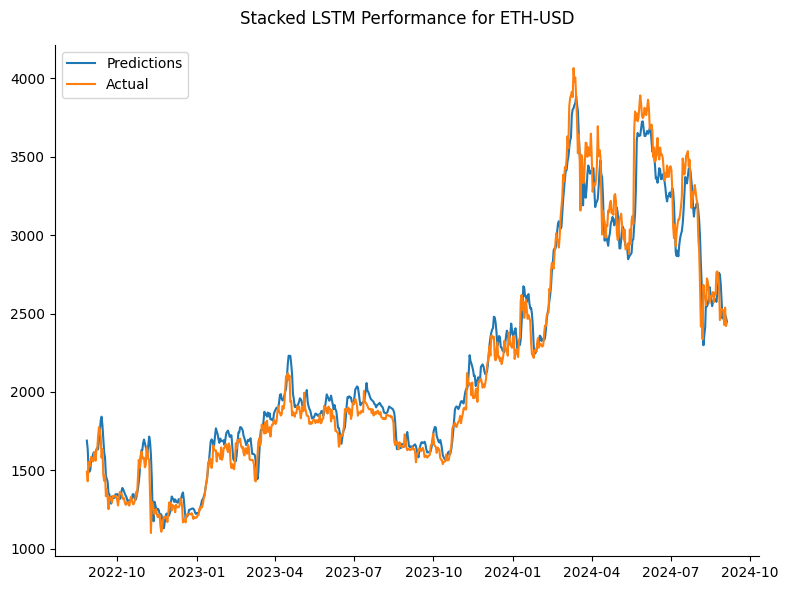

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 
#
#Plotting
plt.plot_date(test.index[lag:], predictions, label = "Predictions", fmt = "-")
plt.plot_date(test.index[lag:], actual, label = "Actual", fmt = "-")
plt.title("Stacked LSTM Performance for " + str(ticker), pad = 15)
plt.legend()
plt.tight_layout()
#
#Metrics
print("Mean Absolute Error: " + str(mean_absolute_error(actual, predictions)))
print("Root Mean Squared Error: " + str(mean_squared_error(actual, predictions, squared=False)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(actual, predictions)))
#
for location in ["top", "right"]:
    plt.gca().spines[location].set_visible(False)

## Forecasting into the Future ##

Because the LSTM Buy, Hold strategy that we test in this study is only concerned with the forecasted prices of tommorow, we forecast only one time step into the future. 

In [70]:
def forecast(features, lookback): #where 'lookback' is the lookback period our model should use to predict the price for tommorow. 
    #  
    recent_values = features.iloc[-lookback:].values #Most recent feature values as an array. 
    #
    from sklearn.preprocessing import MinMaxScaler 
    scaler = MinMaxScaler(feature_range=(0,1)) 
    #
    #Feature Normalization
    vals_scaled = scaler.fit_transform(recent_values)
    #
    #Sequence Construction
    input_sequence = [] #Initializes an empty list. 
    input_sequence.append(recent_values) #Reshapes 'recent_values' as one sequence. 
    input_sequence = np.reshape(input_sequence, (1, recent_values.shape[0], recent_values.shape[1])) #Reshapes 'input_sequence' to align with the expected 'input_shape'. 
    #
    #Prediction
    prediction_normalized = lstm_model.predict(input_sequence) #Uses our trained LSTM to predict the normalized price one time step in the future. 
    #
    #Inverse Transformations
    prediction_matrix = np.zeros(shape = (1, recent_values.shape[1])) 
    prediction_matrix[:, [0]] = prediction_normalized
    prediction_matrix = scaler.inverse_transform(prediction_matrix)
    #
    prediction = prediction_matrix[:, 0] 
    return prediction 

In [71]:
print(forecast(features, lag)) #Forecasted Price
print(features[-1:]) #Closing Price Today. 

1/1 [==============================] - 0s 10ms/step
[2430.79304854]
                  Close       Volume       MACD        RSI
Date                                                      
2024-09-04  2441.243408  16582764544 -94.084602  39.525929


# Walk-Forward Cross Validation #

In [72]:
from sklearn.model_selection import TimeSeriesSplit #To create splits
#
def walk_forward_cv(folds, data, num_features, rsi_lookback, lags, target_index): #The provided 'data' should consist of all non-exogenous features. All exogenous features are
    #calculated within this function. 
    #
    #Initializing empty lists for performance metrics
    mae = [] #Root Mean Squared Error
    rmse = [] #Mean Absolute Error
    mape = [] #Mean Absolute Percentage Error
    training_dates = [] #Dates corresponding to the training data. 
    #
    tsplit = TimeSeriesSplit(n_splits = folds)  #Initializing 'TimeSeriesSplit'. 
    for train_indices, test_indices in tsplit.split(data): 
        #
        sample = data.iloc[np.hstack((train_indices, test_indices))] 
        #
        #Exogenous Features
        sample["MACD"] = macd(sample)
        sample["RSI"] = rsi(sample, rsi_lookback)
        print(sample.iloc[train_indices].index)
        training_dates.append(sample.iloc[train_indices].index)
        #
        training_val, test = sample.iloc[train_indices].dropna(), sample.iloc[test_indices].dropna() 
        #
        #Feature Scaling
        scaler = MinMaxScaler(feature_range=(0,1)) #Reinitializes 'MinMaxScaler' for every new iteration. 
        training_val_scaled = scaler.fit_transform(training_val) 
        test_scaled = scaler.transform(test) 
        #
        #Training and Validation Sets: 80/20 Split. 
        training_scaled = training_val_scaled[:int(0.8 * len(training_val))]
        val_scaled = training_val_scaled[int(0.8 * len(training_val) + 1):]
        #
        #Sequence Construction 
        x_train, y_train = sequences(training_scaled, lag_order= lags, target_index= target_index)
        x_val, y_val = sequences(val_scaled, lag_order=lags, target_index=target_index)
        x_test, y_test = sequences(test_scaled, lag_order=lags, target_index=target_index)
        #
        lstm_model = lstm(keras_tuner.HyperParameters(), input_features = num_features)  #Reinitializes the LSTM model every new iteration. 
        early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, mode = "min") 
        history = lstm_model.fit(x = x_train, y = y_train, batch_size = 10, epochs = 500, validation_data = (x_val, y_val), callbacks = [early_stopping])
        #
        #Predictions 
        predictions_normalized = lstm_model.predict(x_test)
        predictions_matrix = np.zeros(shape = (len(predictions_normalized), num_features)) 
        predictions_matrix[:, [0]] = predictions_normalized #To set an array as a column.
        #
        #Inverse Transformations 
        predictions_matrix = scaler.inverse_transform(predictions_matrix)
        actual_matrix = scaler.inverse_transform(test_scaled) 
        #
        predictions = predictions_matrix[:, 0]; actual = actual_matrix[:,target_index][lags:] 
        #
        #Performance Metrics 
        mae.append(mean_absolute_error(actual, predictions))
        rmse.append(mean_squared_error(actual, predictions, squared = False))
        mape.append(mean_absolute_percentage_error(actual, predictions))
        #
    return mae, rmse, mape, training_dates #Return results

In [73]:
prices_and_volume = prices[["Close", "Volume"]]
results = walk_forward_cv(folds = 10, data = prices_and_volume, num_features = 4, rsi_lookback= 14, lags = 3, target_index=0) #10-Fold Cross-Validation. 

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22',
               '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26',
               '2018-06-27', '2018-06-28'],
              dtype='datetime64[ns]', name='Date', length=232, freq=None)


/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
18/18 [==============================] - 2s 33ms/step - loss: 0.2839 - val_loss: 0.0521
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 0.1689 - val_loss: 0.1819
Epoch 3/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03',
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-09'],
              dtype='datetime64[ns]', name='Date', length=458, freq=None)


/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
36/36 [==============================] - 3s 19ms/step - loss: 0.2088 - val_loss: 0.2374
Epoch 2/500
36/36 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.2275
Epoch 3/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0744 - val_loss: 0.1186
Epoch 4/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 5/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0567
Epoch 6/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0119
Epoch 7/500
36/36 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0397
Epoch 8/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2019-09-14', '2019-09-1

/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
54/54 [==============================] - 4s 32ms/step - loss: 0.1793 - val_loss: 0.0860
Epoch 2/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0536
Epoch 3/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0254
Epoch 4/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0127
Epoch 5/500
54/54 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0126
Epoch 6/500
54/54 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0210
Epoch 7/500
54/54 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0101
Epoch 8/500
54/54 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0105
Epoch 9/500
7/7 [==============================] - 1s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
  

/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
72/72 [==============================] - 3s 10ms/step - loss: 0.1384 - val_loss: 0.0351
Epoch 2/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0378 - val_loss: 0.0106
Epoch 3/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0081
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0102
Epoch 5/500
7/7 [==============================] - 1s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18'],
              dtype='datetime64[ns]', name='Date', length=1136, freq=None)


/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
90/90 [==============================] - 3s 9ms/step - loss: 0.1044 - val_loss: 0.0567
Epoch 2/500
90/90 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0184
Epoch 3/500
90/90 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0376
Epoch 4/500
90/90 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0138
Epoch 5/500
90/90 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0129
Epoch 6/500
90/90 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0174
Epoch 7/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30

/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
108/108 [==============================] - 3s 7ms/step - loss: 0.0367 - val_loss: 0.2810
Epoch 2/500
108/108 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0440
Epoch 3/500
108/108 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0455
Epoch 4/500
108/108 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0347
Epoch 5/500
108/108 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0542
Epoch 6/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09',
               '2022-03-10', '2022-03-11', '2022-03-12', '2022-03-13',
               '2022-03-14', '2022-03-15'],
              dtype='datetime64[ns]', name

/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
126/126 [==============================] - 3s 7ms/step - loss: 0.0469 - val_loss: 0.1043
Epoch 2/500
126/126 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0427
Epoch 3/500
126/126 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0409
Epoch 4/500
126/126 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0393
Epoch 5/500
126/126 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0409
Epoch 6/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27'],
              dtype='datetime64[ns]', name

/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
144/144 [==============================] - 3s 7ms/step - loss: 0.0708 - val_loss: 0.0706
Epoch 2/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0196 - val_loss: 0.0487
Epoch 3/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0263
Epoch 4/500
144/144 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0263
Epoch 5/500
7/7 [==============================] - 1s 2ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2023-06-01', '2023-06-02', '2023-06-03', '2023-06-04',
               '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08',
               '2023-06-09', '2023-06-10'],
              dtype='datetime64[ns]', name='Date', length=2040, freq=None)


/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["MACD"] = macd(sample)
/var/folders/gk/5trqd61s5f385h0bqf717zmh0000gn/T/ipykernel_10923/3514352006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["RSI"] = rsi(sample, rsi_lookback)


Epoch 1/500
162/162 [==============================] - 4s 6ms/step - loss: 0.0747 - val_loss: 0.0247
Epoch 2/500
162/162 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0152
Epoch 3/500
162/162 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0148
Epoch 4/500
162/162 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 5/500
7/7 [==============================] - 0s 1ms/step
DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22'],
              dtype='datetime64[ns]', name='Date', length=2266, freq=None)
Epoch 1/500
180/180 [==============================] - 3s 6ms/step -

In [74]:
print(results[0]) #MAE
print(results[1]) #RMSE
print(results[2]) #MAPE

[343.35933889940446, 136.50317395140834, 14.743642025753246, 29.816584730808298, 526.1213051216998, 500.9720929286922, 120.0562649749533, 53.40858290271779, 110.77312224889941, 175.07381021153915]
[359.49157804927614, 149.47664506751696, 17.619561479125338, 35.89186638853126, 646.2986274951428, 565.2293212628585, 159.63213933259303, 77.64405327008159, 126.58858207512388, 217.77639599164604]
[2.1787529361068763, 0.6732397075273379, 0.08739115848763002, 0.09194111232533084, 0.23342091756530242, 0.13733434697471497, 0.06725179790163807, 0.03470680345098389, 0.057443160834732616, 0.05584687973794055]


# Backtesting Trading Strategy #

## 5 & 15 EMA Crossover: A Simple Buy, Sell Strategy ##

EMA Crossover is a commonly used strategy and, in this study, was backtested to provide a reference against which to determine the potential of the LSTM Buy, Hold Strategy. 

In [75]:
import backtrader as bt
# 
#Defining Simple Buy/Sell MACD strategy
class MACD_BuySell(bt.Strategy):
    #
    params = (
        ("pshort", 5), #Period for Short-Term Exponential Moving Average
        ("plong", 15), #Period for Long-Term Exponential Moving Average
    )
    #
    def __init__(self): 
        ema1 = bt.ind.EMA(period = self.params.pshort) #self.smfactor: Exponential Moving Average
        ema2 = bt.ind.EMA(period = self.params.plong)
        self.crossover = bt.ind.CrossOver(ema1, ema2) #If EMA1 becomes greater than EMA2, then buy. 
        #If EMA1 becoems less than EMA2, then sell. 
    #
    def next(self): 
        if not self.position: #if not currently in the market
            if self.crossover > 0: #Positive Crossover Signal (EMA1 > EMA2)
                self.buy()
        elif self.crossover < 0: #Negative Crossover Signal (EMA1 < EMA2)
            self.sell() #Sell all stakes that were bought. Through a process of continously entering and exiting the market, we expect
            #profits to be made. If no stakes are bought or sold at some moment in time, they are held. 
#
cerebro = bt.Cerebro() #Helps to aggregate data and strategies to then backtest those strategies to produce profit and loss results
#
#Dataset
data = bt.feeds.PandasData(dataname = prices_and_exogenous_features.iloc[int(0.7 * len(prices_and_exogenous_features) + 1):]) 
cerebro.adddata(data) 
#
#Initial Cash
cerebro.broker.setcash(10000.0)
#
#Strategy or Strategies
cerebro.addstrategy(MACD_BuySell)
cerebro.addsizer(bt.sizers.SizerFix, stake = 1) #How many stakes per every trade.
#
#
cerebro.run(writer = True) #Prints results. 

Cerebro:
  -----------------------------------------------------------------------------
  - Datas:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - Data0:
      - Name: 
      - Timeframe: Days
      - Compression: 1
  -----------------------------------------------------------------------------
  - Strategies:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - MACD_BuySell:
      *************************************************************************
      - Params:
        - pshort: 5
        - plong: 15
      *************************************************************************
      - Indicators:
        .......................................................................
        - EMA:
          - Lines: ema
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
          - Params:
            - period: 15
        ..............................................................

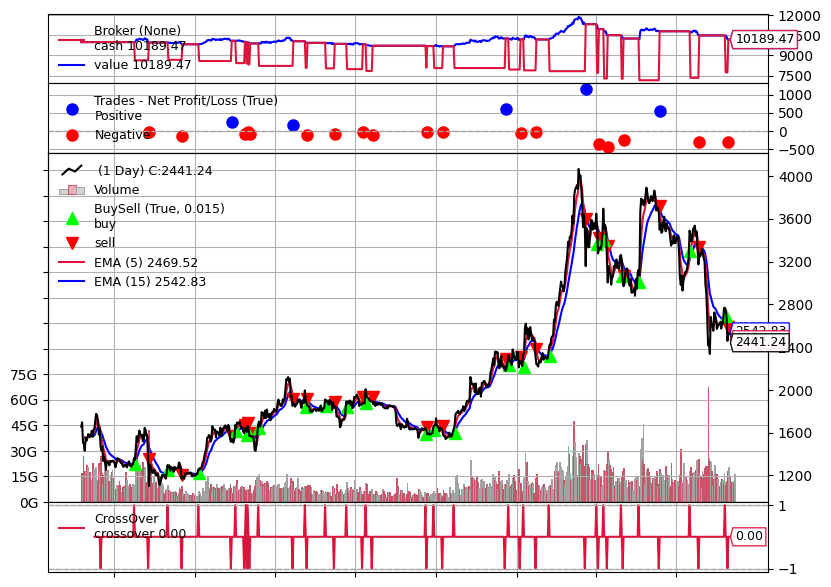

[[<Figure size 800x600 with 5 Axes>]]

In [76]:
cerebro.plot(iplot = False)

## LSTM Trading ##

In [77]:
import backtrader.feeds as btfeeds
class PandasData(btfeeds.PandasData): #Additional lines for each provided dataframe
    lines = ("macd", "rsi") #Adds lines for exogenous features. 
    params = (("macd", -1), ("rsi", -1)) #Adds parameters beyond those inherited from the base class. 'macd' is index 8, and 'rsi' is index 9. 

In [78]:
class Prediction(bt.Indicator):
    lines = ("prediction", ) #Corresponding line associated with the indicator in development here. Each indicator must have a corresponding line object that
    #can be plotted and used as a way to reference that indicator. 
    #
    params = (("lookback", 3), ) #Debugging: make sure to add ',' in the case of only one parameter. 
    #
    def __init__(self): 
        self.addminperiod(self.params.lookback) #Needs three days given the lookback period before any forecasts can be made. 
    def next(self): 
        features = pd.DataFrame(data = [self.data.close.get(size = self.p.lookback), 
                                        self.data.volume.get(size = self.p.lookback), 
                                        self.data.macd.get(size = self.p.lookback),
                                        self.data.rsi.get(size = self.p.lookback)]).T
        # 
        self.lines.prediction[0] = forecast(features= features, lookback= self.p.lookback) 

## Backtesting the LSTM Buy, Hold Strategy ##

In [79]:
from backtrader import Strategy
class LSTM_BuyHold(bt.Strategy): #Ultimately, how well the strategy works is contigent on how accurately our LSTM predicts the given security. 
    def __init__(self):
        self.prediction = Prediction() #Define developed indicators. 
    def next(self):
        if not self.position: #If not currently in market. 
            if self.prediction > self.data.close: #If the prediction for tommorow is greater than the closing price of today, buy. In all other cases, hold. 
                self.buy()
        else: #If already in the market 
            if self.prediction > self.data.close:
                self.buy() #Otherwise, hold. 
#
cerebro = bt.Cerebro()  
#
#Datafeed
data = PandasData(dataname = prices_and_exogenous_features.iloc[int(0.7 * len(prices_and_exogenous_features) + 1):]) #Debugging: since you extended the datafeed, you need to use 
#`PandasData` and not `bt.feeds.PandasData`. 
cerebro.adddata(data) 
#
#Initial Cash
cerebro.broker.setcash(10000.0)
#
cerebro.addstrategy(LSTM_BuyHold)
cerebro.addsizer(bt.sizers.SizerFix, stake = 1) #Debugging: make sure you have enough funds to buy as many stakes as you seek to
#per every buy order. 
# 
cerebro.run(writer = True) #Prints results. 

1/1 [==============================] - 0s 11ms/step
Cerebro:
  -----------------------------------------------------------------------------
  - Datas:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - Data0:
      - Name: 
      - Timeframe: Days
      - Compression: 1
  -----------------------------------------------------------------------------
  - Strategies:
    +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    - LSTM_BuyHold:
      *************************************************************************
      - Params:
      *************************************************************************
      - Indicators:
        .......................................................................
        - Prediction:
          - Lines: prediction
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
          - Params:
            - lookback: 3
      *************************************

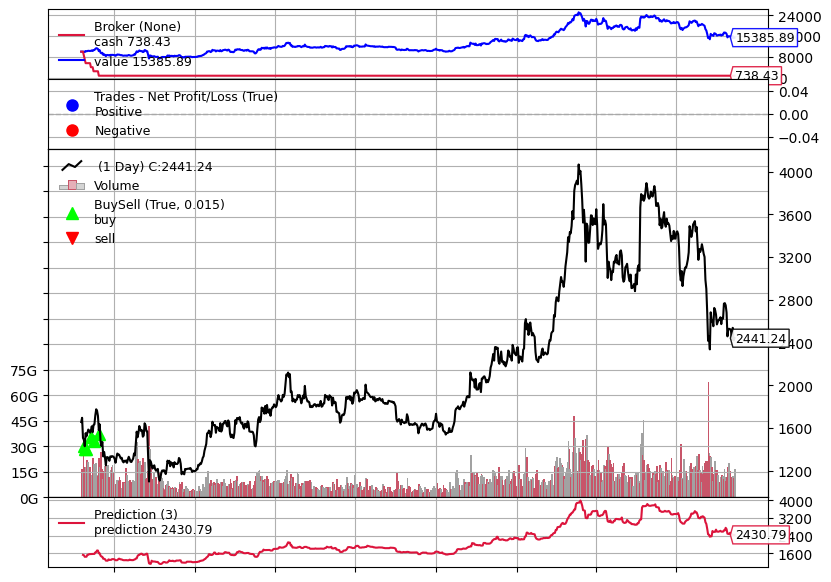

[[<Figure size 800x600 with 5 Axes>]]

In [80]:
cerebro.plot(iplot = False)